# ITU 5G Energy Consumption Challenge - GitData

<font color="red">Please make a copy of this Jupyter Notebook to your own Google Drive or local machine before changing anything.</font>

This Jupyter Notebook will also be updated regularly on GitHub: https://github.com/GitData-GA/itu5g/tree/main/code/ITU_5G_Energy_Consumption_Challenge.ipynb

In [1]:
# Import all libraries here
import random
random.seed(88)
import pandas as pd
import numpy as np
np.random.seed(88)
import tensorflow as tf
tf.random.set_seed(88)
from tensorflow import keras
keras.utils.set_random_seed(88)
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt

## Data Preparation

In [2]:
# Output format
# Description: The file contains days, hours, and base stations for which we
# need energy consumption estimation and will be used for scoring predictions.
power_pred = pd.read_csv('https://data.gd.edu.kg/bwz7t527/power_consumption_prediction.csv')
# Dataset 1
# Description: Energy consumption data (ECdata.csv): include hour-level energy
# consumption specifications (e.g., total energy consumption of the base stations).
ECdata = pd.read_csv('https://data.gd.edu.kg/bwz7t527/ECdata.csv')
# Dataset 2
# Description: Cell-level data (CLdata.csv): include hour-level counters,
# including service compliance counters (e.g., load) and energy-saving methods
# counters (e.g., duration of energy saving mode activation).
CLdata = pd.read_csv('https://data.gd.edu.kg/bwz7t527/CLdata.csv')
# Dataset 3
# Description: Base Station basic information (BSinfo.csv): include
# configuration parameters and hardware attributes
BSinfo = pd.read_csv('https://data.gd.edu.kg/bwz7t527/BSinfo.csv')

In [17]:
weights = power_pred[['BS', 'w']].drop_duplicates().reset_index(drop=True)
weights.loc[weights.shape[0] + 1] = ['B_924', 1]
weights.loc[weights.shape[0] + 1] = ['B_946', 1]
weights

,BS,w
0,B_0,1
1,B_1,1
2,B_2,1
3,B_3,1
4,B_4,1
...,...,...
1015,B_1017,5
1016,B_1018,1
1017,B_1019,5
1019,B_924,1


In [3]:
CL_BS = CLdata.merge(BSinfo, on=['BS', 'CellName'], how='left')
CL_BS = CL_BS.pivot(
    index=['Time', 'BS'],
    columns=['CellName'],
    values=['load', 'ESMode1', 'ESMode2', 'ESMode3',
       'ESMode4', 'ESMode5', 'ESMode6', 'Frequency',
       'Bandwidth', 'Antennas', 'TXpower'],
).reset_index()

CL_BS.columns = ['_'.join([str(i) for i in x]) for x in CL_BS.columns]
CL_BS.columns = CL_BS.columns.str.strip('_')
CL_BS = CL_BS.merge(BSinfo.groupby('BS')[['RUType', 'Mode']].first().reset_index(), on='BS', how='left')
data = CL_BS.merge(ECdata, on=['Time', 'BS'], how='left')

data['Time'] = pd.to_datetime(data['Time'])

data.sort_values(by='Time', inplace=True)
data['Year'] = data['Time'].dt.year
data['Month'] = data['Time'].dt.month
data['Day'] = data['Time'].dt.day
data['Hour'] = data['Time'].dt.hour

first_column = data.pop('Hour')
data.insert(0, 'Hour', first_column)
first_column = data.pop('Day')
data.insert(0, 'Day', first_column)
first_column = data.pop('Month')
data.insert(0, 'Month', first_column)
first_column = data.pop('Year')
data.insert(0, 'Year', first_column)

categorical_cols = ['BS', 'RUType', 'Mode']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Training data
train_data = data.dropna()

# Extract target variable 'Energy' and 'Time'
y = train_data['Energy']
time_train = train_data['Time']
train_data = train_data.drop(columns=['Energy', 'Time'])

# Standardize numerical features
scaler = StandardScaler()
train_data[train_data.columns] = scaler.fit_transform(train_data[train_data.columns])

# Data need to predict
unknown_data = data[data.isna().any(axis=1)]
time_unknown = unknown_data['Time']
unknown_data = unknown_data.drop(columns=['Energy', 'Time'])

# Standardize numerical features
unknown_data[unknown_data.columns] = scaler.fit_transform(unknown_data[unknown_data.columns])

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, shuffle=False)

# Convert data to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Time series transformation
X_train_ts = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_ts = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [4]:
# Decide when the model should stop
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [7]:
# LSTM Model - Time series
lstm_model = keras.Sequential([
    # layers.Dense(units=64, activation='relu'),
    layers.LSTM(units=128, recurrent_dropout=0.1225),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
lstm_model.compile(optimizer='Adam', loss='mean_absolute_percentage_error',
                   metrics=['mean_absolute_percentage_error'])

# Train the model
history = lstm_model.fit(X_train_ts, y_train, epochs=500, batch_size=32,
                         validation_split=0.2)

# Fit model on validation set and get error
y_pred = lstm_model.predict(X_test_ts)
mape_lstm = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape_lstm:.5f}%')

lstm_model.summary()

Epoch 1/500
1/1 [==============================] - 6s 6s/step - loss: 101.7749 - mean_absolute_percentage_error: 101.7749 - val_loss: 100.0059 - val_mean_absolute_percentage_error: 100.0059
Epoch 2/500
1/1 [==============================] - 0s 90ms/step - loss: 101.5512 - mean_absolute_percentage_error: 101.5512 - val_loss: 99.9979 - val_mean_absolute_percentage_error: 99.9979
Epoch 3/500
1/1 [==============================] - 0s 86ms/step - loss: 102.0545 - mean_absolute_percentage_error: 102.0545 - val_loss: 99.9910 - val_mean_absolute_percentage_error: 99.9910
Epoch 4/500
1/1 [==============================] - 0s 103ms/step - loss: 101.1146 - mean_absolute_percentage_error: 101.1146 - val_loss: 99.9884 - val_mean_absolute_percentage_error: 99.9884
Epoch 5/500
1/1 [==============================] - 0s 110ms/step - loss: 101.3206 - mean_absolute_percentage_error: 101.3206 - val_loss: 99.9866 - val_mean_absolute_percentage_error: 99.9866
Epoch 6/500
1/1 [==============================]

## Model Training

In [ ]:
# Define and compile the model
lstm_model = keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, recurrent_dropout=0.15),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.LSTM(units=64),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Use a learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,  # You can adjust this initial learning rate
    decay_steps=10000,
    decay_rate=0.9
)

# Compile the model with the RMSProp optimizer and the learning rate schedule
lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                   loss='mean_absolute_percentage_error',
                   metrics=['mean_absolute_percentage_error'])

# Train the model with early stopping and more epochs
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = lstm_model.fit(X_train_ts, y_train, epochs=200, batch_size=32,
                         validation_split=0.2, callbacks=[callback])

# Evaluate the model on the test set
y_pred = lstm_model.predict(X_test_ts)
mape_lstm = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape_lstm:.5f}%')

lstm_model.summary()

Epoch 1/200
1853/1853 [==============================] - 72s 18ms/step - loss: 204.7167 - mean_absolute_percentage_error: 204.7167 - val_loss: 132.7154 - val_mean_absolute_percentage_error: 132.7154
Epoch 2/200
1853/1853 [==============================] - 30s 16ms/step - loss: 124.3083 - mean_absolute_percentage_error: 124.3083 - val_loss: 106.3325 - val_mean_absolute_percentage_error: 106.3325
Epoch 3/200
1853/1853 [==============================] - 31s 17ms/step - loss: 96.1224 - mean_absolute_percentage_error: 96.1224 - val_loss: 99.8559 - val_mean_absolute_percentage_error: 99.8559
Epoch 4/200
1853/1853 [==============================] - 29s 16ms/step - loss: 82.6681 - mean_absolute_percentage_error: 82.6681 - val_loss: 99.3724 - val_mean_absolute_percentage_error: 99.3724
Epoch 5/200
1853/1853 [==============================] - 30s 16ms/step - loss: 75.8721 - mean_absolute_percentage_error: 75.8721 - val_loss: 97.7172 - val_mean_absolute_percentage_error: 97.7172
Epoch 6/200
1853/

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

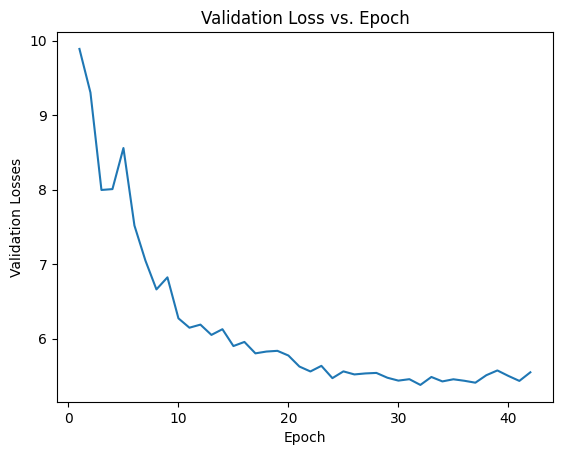

In [ ]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

In [ ]:
# GRU Model - Time series
gru_model = keras.Sequential([
    layers.GRU(units=128, return_sequences=True, recurrent_dropout=0.15),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.GRU(units=64),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model with the RMSProp optimizer and the learning rate schedule
gru_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                   loss='mean_absolute_percentage_error',
                   metrics=['mean_absolute_percentage_error'])

# Train the model with early stopping and more epochs
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = gru_model.fit(X_train_ts, y_train, epochs=200, batch_size=32,
                         validation_split=0.2, callbacks=[callback])

# Fit model on validation set and get error
y_pred = gru_model.predict(X_test_ts)
mape_gru = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape_gru:.5f}%')

gru_model.summary()

Epoch 1/200
1962/1962 [==============================] - 38s 15ms/step - loss: 25.3840 - mean_absolute_percentage_error: 25.3840 - val_loss: 9.6610 - val_mean_absolute_percentage_error: 9.6610
Epoch 2/200
1962/1962 [==============================] - 31s 16ms/step - loss: 15.2510 - mean_absolute_percentage_error: 15.2510 - val_loss: 8.7152 - val_mean_absolute_percentage_error: 8.7152
Epoch 3/200
1962/1962 [==============================] - 31s 16ms/step - loss: 13.3596 - mean_absolute_percentage_error: 13.3596 - val_loss: 8.1628 - val_mean_absolute_percentage_error: 8.1628
Epoch 4/200
1962/1962 [==============================] - 31s 16ms/step - loss: 12.3053 - mean_absolute_percentage_error: 12.3053 - val_loss: 7.6126 - val_mean_absolute_percentage_error: 7.6126
Epoch 5/200
1962/1962 [==============================] - 29s 15ms/step - loss: 11.4013 - mean_absolute_percentage_error: 11.4013 - val_loss: 7.6264 - val_mean_absolute_percentage_error: 7.6264
Epoch 6/200
1962/1962 [============

In [ ]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

In [ ]:
# RNN Model - Time series
rnn_model = keras.Sequential([
    layers.SimpleRNN(units=128, return_sequences=True, recurrent_dropout=0.2),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.SimpleRNN(units=64, recurrent_dropout=0.2),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model with the RMSProp optimizer and the learning rate schedule
rnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                   loss='mean_absolute_percentage_error',
                   metrics=['mean_absolute_percentage_error'])

# Train the model with early stopping and more epochs
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = rnn_model.fit(X_train_ts, y_train, epochs=200, batch_size=32,
                         validation_split=0.2, callbacks=[callback])

# Fit model on validation set and get error
y_pred = rnn_model.predict(X_test_ts)
mape_rnn = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape_rnn:.5f}%')

rnn_model.summary()

In [ ]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

In [ ]:
# Regression Model - Regression
model_reg = keras.Sequential([
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
model_reg.compile(optimizer='Adam', loss='mean_absolute_percentage_error',
                   metrics=['mean_absolute_percentage_error'])

# Train the model
history = model_reg.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_split=0.2, callbacks = [callback])

# Fit model on validation set and get error
y_pred = model_reg.predict(X_test)
mape_reg = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape_reg:.5f}%')

model_reg.summary()

Epoch 1/50
1962/1962 [==============================] - 11s 5ms/step - loss: 23.6316 - mean_absolute_percentage_error: 23.6316 - val_loss: 8.8675 - val_mean_absolute_percentage_error: 8.8675
Epoch 2/50
1962/1962 [==============================] - 10s 5ms/step - loss: 13.8491 - mean_absolute_percentage_error: 13.8491 - val_loss: 8.3412 - val_mean_absolute_percentage_error: 8.3412
Epoch 3/50
1962/1962 [==============================] - 9s 5ms/step - loss: 12.3509 - mean_absolute_percentage_error: 12.3509 - val_loss: 8.1637 - val_mean_absolute_percentage_error: 8.1637
Epoch 4/50
1962/1962 [==============================] - 9s 5ms/step - loss: 11.3604 - mean_absolute_percentage_error: 11.3604 - val_loss: 7.0709 - val_mean_absolute_percentage_error: 7.0709
Epoch 5/50
1962/1962 [==============================] - 9s 5ms/step - loss: 10.6404 - mean_absolute_percentage_error: 10.6404 - val_loss: 7.9660 - val_mean_absolute_percentage_error: 7.9660
Epoch 6/50
1962/1962 [==========================

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

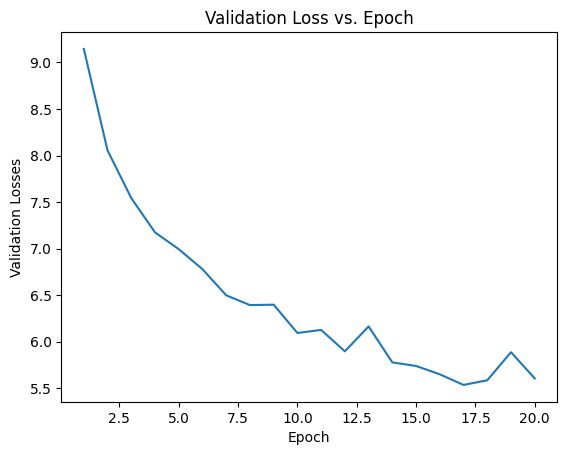

In [ ]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

## Generate Result

In [ ]:
# Convert data to numpy arrays
unknown_test = unknown_data.to_numpy()

# Time series transformation
#unknown_test = unknown_test.reshape(unknown_test.shape[0], 1, unknown_test.shape[1])

# Get result (need to choose a model)
y_unknown = model_reg.predict(unknown_test)

860/860 [==============================] - 1s 2ms/step


In [ ]:
# Append result to the dataframe
pd.DataFrame(y_unknown)
data_copy = data_copy[data_copy.isna().any(axis=1)]
data_copy = data_copy.loc[:, ['Time', 'BS']]
data_copy['Energy'] = y_unknown
data_copy

,Time,BS,Energy
14550,2023-01-01 01:00:00,B_105,43.280811
45456,2023-01-01 01:00:00,B_328,19.372030
7212,2023-01-01 01:00:00,B_52,21.808880
35266,2023-01-01 01:00:00,B_255,17.870972
52652,2023-01-01 01:00:00,B_380,17.906210
...,...,...,...
90481,2023-01-08 00:00:00,B_650,27.700439
90055,2023-01-08 00:00:00,B_647,12.424007
108546,2023-01-08 00:00:00,B_781,46.935307
89913,2023-01-08 00:00:00,B_646,12.268379


In [ ]:
# Merge result above to power prediction
power_pred['Time'] = pd.to_datetime(power_pred['Time'])
power_pred.drop(columns=['Energy'], inplace=True)
power_pred = power_pred.merge(data_copy, on=["Time", "BS"], how="left")
power_pred

# Group by 'Time' and 'BS', calculate the mean of 'Energy', and reset the index
averaged_df = power_pred.groupby(['Time', 'BS'])['Energy'].mean().reset_index()

# Merge the averaged values back to the original DataFrame
df = power_pred.merge(averaged_df, on=['Time', 'BS'], suffixes=('', '_avg'), how='left')

# Drop the duplicate rows and unnecessary columns
df.drop_duplicates(subset=['Time', 'BS'], keep='first', inplace=True)
df.drop(columns=['Energy'], inplace=True)
df.rename(columns={'Energy_avg': 'Energy'}, inplace=True)

# Create a new DataFrame with switched columns
df_switched = df[['Time', 'BS', 'Energy', 'w']]

# Reset the index
df_switched.reset_index(drop=True, inplace=True)

# Change datetime to string
df_switched['Time'] = df_switched['Time'].astype('str')

# Merge time and BS with a "_" to meet the submission requirement
df_switched['Time'] = df_switched['Time'] + '_' + df_switched['BS']
df_switched = df_switched.drop(columns=["BS"])
df_switched

,Time,Energy,w
0,2023-01-01 06:00:00_B_0,41.692425,1
1,2023-01-01 11:00:00_B_0,54.410717,1
2,2023-01-01 12:00:00_B_0,53.363819,1
3,2023-01-01 13:00:00_B_0,54.335079,1
4,2023-01-01 23:00:00_B_0,58.779362,1
...,...,...,...
26134,2023-01-02 19:00:00_B_1019,20.737875,5
26135,2023-01-02 20:00:00_B_1019,20.495638,5
26136,2023-01-02 21:00:00_B_1019,20.254726,5
26137,2023-01-02 22:00:00_B_1019,19.958185,5


In [ ]:
# Generate result to submit
df_switched.to_csv('result_GitData.csv', index=False)